### Pothole Detection using Resnet

In [22]:
from pathlib import Path
import torch
from fastai.basic_data import DatasetType
from fastai.callbacks import SaveModelCallback
from fastai.metrics import accuracy
from fastai.train import ClassificationInterpretation
from fastai.vision.data import ImageList
from fastai.vision.learner import cnn_learner
from fastai.vision.models import resnet18, resnet34
from fastai.vision.transform import ResizeMethod, get_transforms
from fastai.vision import imagenet_stats
from fastai.vision import defaults

import pandas as pd

### Data

The first thing we want to do is create a fastai databunch. This object contains all the information on how we want the data to be retrieved and processed before it gets sent to the model and optimiser. In this challenge we are dealing with image. *Insert info on the images here*.

The things we want to specify in the databunch are:

- where are the images?
- which of them do we want to use for training and which for testing?
- how should the images be labelled?
- what transforms and other preprocessing should be applied to the images before it is passed to the model?
- how big should the batches be?

All of this is done in the cell below:

In [2]:
path = Path.cwd()
img_list = ImageList.from_csv(path, 'train_ids_labels.csv', folder='all_data', suffix='.JPG')
train_val_test_data = img_list.split_by_rand_pct(0.15)
label_lists = train_val_test_data.label_from_df()
label_lists = label_lists.transform(get_transforms(), size=224)
data = label_lists.databunch(bs=8).normalize(imagenet_stats)

Let's check how image list looks like

In [5]:
img_list

ImageList (4026 items)
Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800)
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master

Add test set to the databunch

In [3]:
test_data = ImageList.from_csv(path, 'test_ids_only.csv', folder='all_data', suffix='.JPG')
data.add_test(test_data)

In [6]:
test_data

ImageList (1650 items)
Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800)
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master

Now databunch looks like this:

In [4]:
data

ImageDataBunch;

Train: LabelList (3423 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,1,0
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master;

Valid: LabelList (603 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,0,1
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master;

Test: LabelList (1650 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master

We can show a random batch of images using the show_batch method.



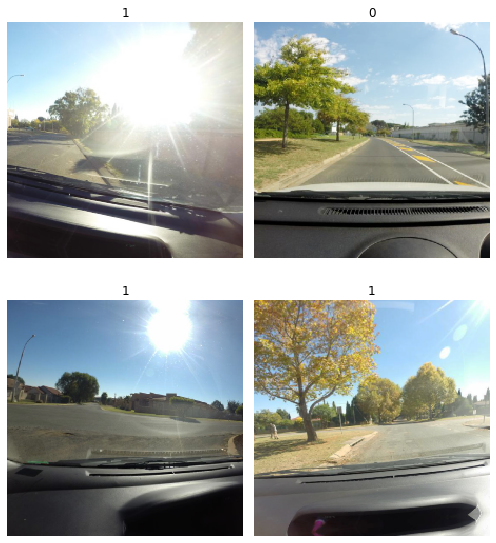

In [10]:
data.show_batch(rows=2, figsize=(7, 8))

### Model

The FastAI library is designed to let you create models (FastAi calls them learners) with only a few lines of code. They provide a method called `cnn_learner`, which can be used to create a convolutional neural network.

The object we got contains everything we need to train the model, including: the databunch, model, loss function and optimiser. 

In [11]:
learn = cnn_learner(data, resnet18, metrics=accuracy)

The created model uses the resnet18 architecture, with weights pretrained on the imagenet dataset.

By default, only the fully connected layers at the top are unfrozen (can be trained), which if you are familiar with transfer learning makes perfect sense.

We are telling cnn_learner to use a ResNet18 and that we want to see the accuracy reported after every epoch. The other required information is derived from the data and/or set by default. For example, look at the chosen loss function and optimiser with the properies `learn.loss_func` and `learn.opt_func`, respectively.

In [12]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [13]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

By default in the background, the head of the network was replaced with the appropriate size classification layer and all but the last layer was frozen (meaning that only the last layer's weights will be tuned during training).

### Train

To train the layers we can use the fit or fit_one_cycle method. The fit method is the “normal” way of training a neural net with a constant learning rate, whilst the fit_one_cycle method uses something called the 1 cycle policy, which basically changes the learning rate over time to achieve better results.

We are going to use the tried and test 1cycle training strategy, so all we need now is to determine a good learning rate.

In [25]:
learn.purge()

Learner(data=ImageDataBunch;

Train: LabelList (3423 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,1,0
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master;

Valid: LabelList (603 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,0,1
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master;

Test: LabelList (1650 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: D:\private\zindi\PotholeImageClassificationChallenge\PotHoleDetection-master, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

To use our 1cycle policy we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using lr_finder. It will do a mock training by going over a large range of learning rates, then plot them against the losses. We will pick a value a bit before the minimum, where the loss still improves. Our graph would look something like this:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


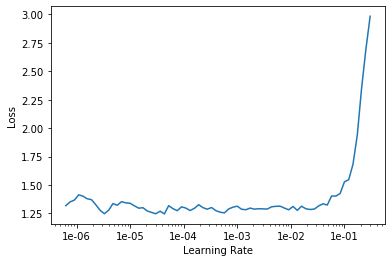

In [16]:
learn.lr_find()
learn.recorder.plot()

Here anything between 5x10^-6 and 10^-5 is a good idea.

In [17]:
lr = 1e-5

Now we can start training. The first argument is the number of epoch we would like to run (remember, here we are only training the last layer, since all the others are frozen.)

In [26]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.278938,0.712886,0.645108,02:53
1,1.108946,0.589217,0.734660,02:57
2,1.121599,0.559410,0.759536,02:57
3,0.976916,0.549038,0.752902,03:00


In [27]:
learn.save('model-1')

Now that the fully-connected layers are well trained we can unfreeze the other layers and train the whole network.

FastAI provides another technic to enhance transfer learning called differential learning rates, which allows us to set different learning rates for different parts in the network.

To find the perfect learning rates we can use the lr_find and recorder.plot methods which create a plot that relates the learning rate with the loss.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


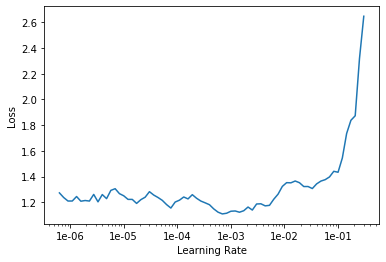

In [28]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

To now train the model using differential learning rates we need to pass the max_lr argument to the fit_one_cycle method.

In [29]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 4e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.663479,0.399673,0.873964,03:24
1,0.446289,0.403375,0.864013,03:24
2,0.326788,0.175660,0.925373,03:27
3,0.288675,0.161829,0.927032,03:28


In [30]:
learn.save('model-2')

### Interpretation

we can use FastAIs ClassificationInterpretation class to interpret our results. To create an interpretation object we need to call the from_learner method and pass it our learner/model. Then we can use methods like plot_confusion_matrix, plot_top_losses or most_confused.

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

Plot confusion matrix:

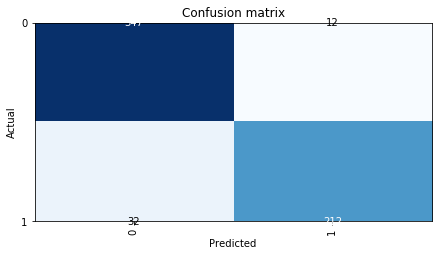

In [32]:
interp.plot_confusion_matrix()

Plot top losses:

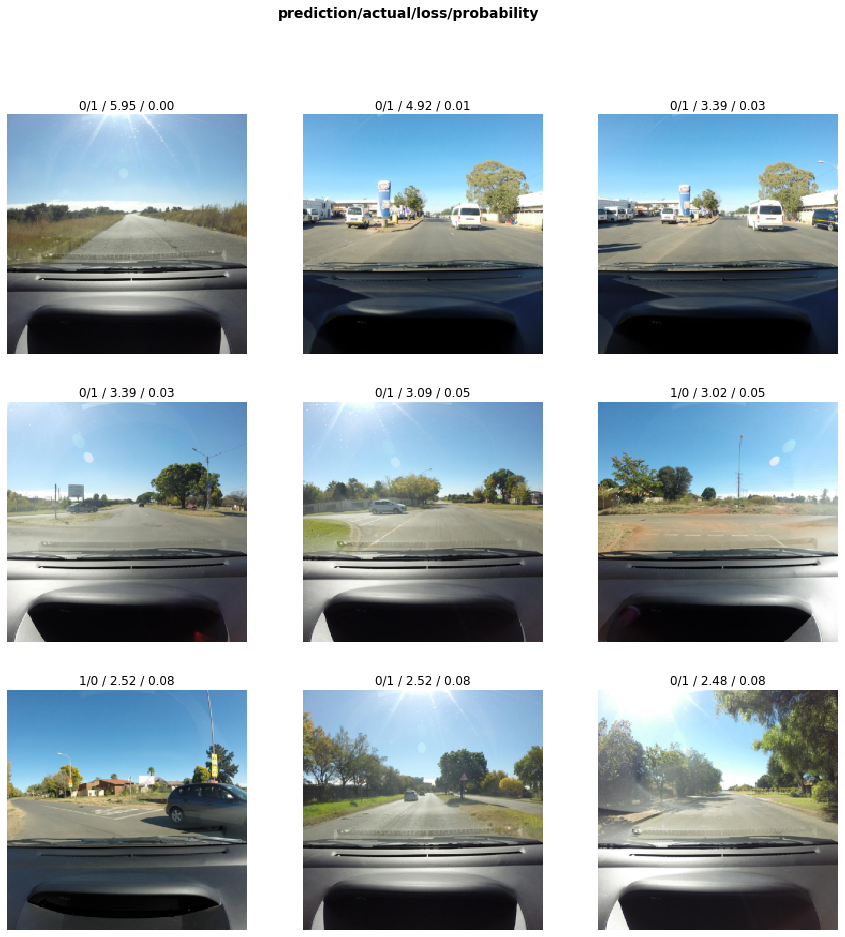

In [33]:
interp.plot_top_losses(9, figsize=(15,15))

To get predictions on the test set, run:

In [35]:
preds, y = learn.get_preds(DatasetType.Test)

In [36]:
preds[:, 1]

tensor([1.3302e-01, 4.6256e-01, 3.7334e-04,  ..., 4.6091e-01, 8.0340e-01,
        9.2655e-02])

In [37]:
fnames = [o.split('\\')[-1].split('.')[0] for o in learn.data.test_ds.items]

In [38]:
predictions = pd.DataFrame({'Image_ID': fnames, 'Label': preds[:, 1]})

In [39]:
predictions.to_csv('results.csv', index=None)